In [1]:
# importing the necessary python modules
# numpy and matplotlib are popular packages for scientific computing and plotting
import numpy as np
import matplotlib.pyplot as plt
import pygmsh

# interactive python (iPython) magic to instruct jupyter how to show the plots with respect to the code cells
%matplotlib inline

# various plotting parameters
plt.rcParams['text.usetex'] = False
plt.rcParams['axes.labelsize'] = 12

# scipy is an extension for numpy, used extensively in scientific computing
# we will use it to build sparse matrices
from scipy.sparse import linalg
from scipy.sparse import lil_matrix, csc_matrix

# here we import the functions translated from matlab
# to do so, we need to change the relative path
import sys
sys.path.append('../FEM')

from Mesher import Mesh
import Matrix
import PoroElasticProperties as prop

### Welcome to the course!

We will use `python` and it's many computing libraries to do finite element computations. Here are some of the libraries we will use:

- `numpy` stands for *numerical python* and is the main library used, along with `scipy`, for scientific computing. It is built with `matlab` in mind and reuses some of the naming conventions used there. You can access the documentation [here](https://numpy.org/doc/stable/).
- `matplotlib`, the main library for plotting purposes. Just like `numpy`, it is built with `matlab` conventions in mind. The documentation is accessible [here](https://matplotlib.org/stable/index.html).
- `pygmsh` is a python wrapper for the popular finite element mesher `gmsh`. We will generate the meshes with this library and manipulate it's output with our own code. `pygmsh` is less used than the two precedent libraries. As a result, it's [documentation](https://pygmsh.readthedocs.io/en/latest/index.html) is less thorough. We will try to give you enough understanding of how it works in the following examples.

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

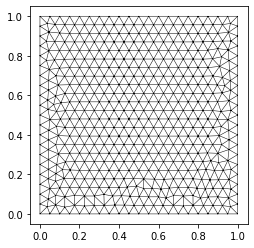

In [2]:
# We can use pygmsh with the following convention

# We create a pygmsh.geo.Geometry object and use it as geom in python's context manager. 
# You don't need to understand the previous sentence. 
# You however need to understand the somewhat intuitive following lines.

# You can easily build a rectangle with the following code:
with pygmsh.geo.Geometry() as geom:
    rec = geom.add_rectangle(0, 1, 0, 1, 0, mesh_size=0.05)
    out = geom.generate_mesh()

# We use the object generated by pygmsh (a meshio object) and manipulate it with our house code
mesh = Mesh(out)
mesh.plot()

This ``Mesh`` object has many properties. Along as a convenient `mesh.plot` function, the ones we will be using the most are ``mesh.nodes`` and ``mesh.connectivity``, telling us the nodes' ``x`` and ``y`` coordinates along as to which nodes they are connected to. ``mesh.nodes`` is then an array of shape ``(number of nodes, 2)`` and ``mesh.connectivity`` is of shape ``(number of elements, 3)``. The number of nodes is stored in ``mesh.nn`` and the number of elements in `mesh.ne`

In [3]:
print(f'mesh.nodes has shape of {mesh.nodes.shape}')
print(f'mesh.connectivity has shape of {mesh.connectivity.shape}')

print(f'mesh.nn is then {mesh.nn}')
print(f'mesh.ne is then {mesh.ne}')


mesh.nodes has shape of (513, 2)
mesh.connectivity has shape of (944, 3)
mesh.nn is then 513
mesh.ne is then 944


The problem given says that the analytical solution of a Laplacian problem is

$$h(x, y) = \frac{\sin(\pi x) \sinh(\pi y)}{\sinh(\pi)},$$

and the fluxes $q_x$ and $q_y$ being

$$q_x (x, y) = \frac{-\pi \cos(\pi x) \sinh(\pi y)}{\sinh(\pi)}$$

and

$$q_y (x, y) = \frac{-\pi \sin(\pi x) \cosh(\pi y)}{\sinh(\pi)}$$


We can compute this solution easily with ``numpy`` and plot it with the ``Mesh`` object:

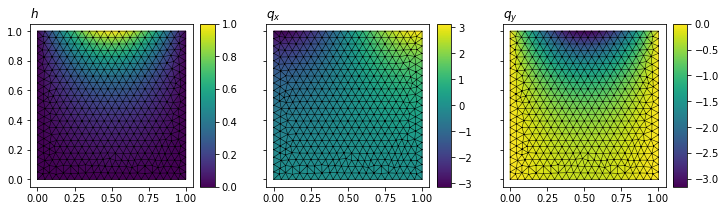

In [4]:
x, y = mesh.nodes[:, 0], mesh.nodes[:, 1]

h = np.sin(np.pi * x) * np.sinh(np.pi * y)/np.sinh(np.pi)
qx = - np.pi * np.cos(np.pi * x) * np.sinh(np.pi * y)/np.sinh(np.pi)
qy = - np.pi * np.sin(np.pi * x) * np.cosh(np.pi * y)/np.sinh(np.pi)

fig, axs = plt.subplots(1, 3, sharey='all', figsize=(12, 3))
mesh.plot(h, ax=axs[0])
mesh.plot(qx, ax=axs[1])
mesh.plot(qy, ax=axs[2])

axs[0].set_title('$h$', loc='left')
axs[1].set_title('$q_x$', loc='left')
axs[2].set_title('$q_y$', loc='left')

for ax in axs:
    ax.set_aspect(1)

### Projection of the flux to the nodes

We would like to compute the fluxes only from the solution obtained ($h$) as we don't always have an analytical solution for them. When computing the derivatives from the head located at the nodes, the solution would be located at the element's centroid. However, this would be a lot more convenient if they were located at the nodes also! We will need to compute a `project_flux` function that computes the fluxes from the heads and project them at the nodes. 

How does this numerical solution compares to the analytical one?

In [5]:
qx_hat, qy_hat = Matrix.project_flux(mesh, 1, h)

c:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


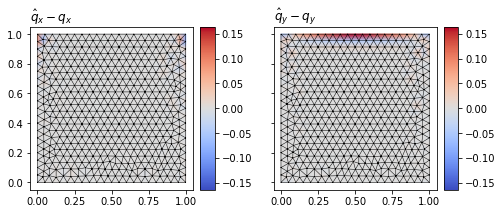

In [9]:
# plotting the errors
errx = qx_hat - qx
erry = qy_hat - qy

vmax = max(np.abs(errx).max(), np.abs(erry).max())

fig, axs = plt.subplots(1, 2, sharey='all', figsize=(8, 3))
mesh.plot(errx, ax=axs[0], vmin=-vmax, vmax=vmax, cmap='coolwarm')
mesh.plot(erry, ax=axs[1], vmin=-vmax, vmax=vmax, cmap='coolwarm')

axs[0].set_title('$\hat{q}_x - q_x$ ', loc='left')
axs[1].set_title('$\hat{q}_y -q_y$', loc='left')

for ax in axs:
    ax.set_aspect(1)

<ipython-input-17-40c44039010c>:2: RuntimeWarning: divide by zero encountered in true_divide
  errx = (qx_hat - qx)/qx
<ipython-input-17-40c44039010c>:3: RuntimeWarning: divide by zero encountered in true_divide
  erry = (qy_hat - qy)/qy


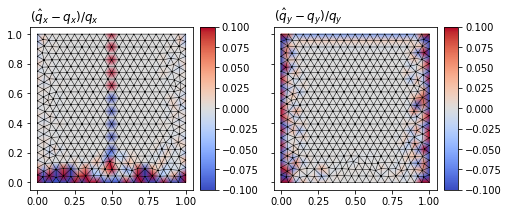

In [17]:
# plotting the relative error
errx = (qx_hat - qx)/qx
erry = (qy_hat - qy)/qy

vmax = max(np.abs(errx).max(), np.abs(erry).max())

fig, axs = plt.subplots(1, 2, sharey='all', figsize=(8, 3))
_, _, cb = mesh.plot(errx, ax=axs[0], vmin=-vmax, vmax=vmax, cmap='coolwarm')
mesh.plot(erry, ax=axs[1], vmin=-vmax, vmax=vmax, cmap='coolwarm')

axs[0].set_title('$(\hat{q}_x - q_x)/q_x$ ', loc='left')
axs[1].set_title('$(\hat{q}_y -q_y)/q_y$', loc='left')

for ax in axs:
    ax.set_aspect(1)
